## Описание проекта <a name="description"></a>

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
Тариф «Смарт»  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

# Примечание к тарифу

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Все даты в приведенных таблицах имеют тип object, их необходимо перевести в datetime. В таблицах нет пропусков, за исключением users['churn_date'], дата прекращения пользования тарифом, если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')
messages['message_date'] =  pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')
internet['session_date'] =  pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')
users['reg_date'] =  pd.to_datetime(users['reg_date'], format ='%Y-%m-%d')
users['churn_date'] =  pd.to_datetime(users['churn_date'], format ='%Y-%m-%d')

In [9]:
calls[calls.duplicated()]

,id,call_date,duration,user_id


In [10]:
messages[messages.duplicated()]

,id,message_date,user_id


In [11]:
internet[internet.duplicated()]

,Unnamed: 0,id,mb_used,session_date,user_id


In [12]:
users[users.duplicated()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


Дубликаты не обнаружены

In [13]:
calls['duration'] = np.ceil(calls['duration'])

Мегалайн округляет звонки по минутам, время звонка округлено в большую сторону

In [14]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month


## Посчитаем для каждого пользователя смс,минуты и гб

In [15]:
calls_pivot_table = calls.pivot_table(index = ['user_id','month'], values = 'duration',aggfunc = ['sum','count'])
calls_pivot_table.columns = ['sum_duration','count_duration']
calls_pivot_table


sum_duration  count_duration
user_id month                              
1000    5             159.0              22
        6             172.0              43
        7             340.0              47
        8             408.0              52
        9             466.0              58
...                     ...             ...
1498    10            247.0              41
1499    9              70.0               9
        10            449.0              68
        11            612.0              74
        12            492.0              69

[3174 rows x 2 columns]

In [16]:
messages_pivot_table = messages.pivot_table(index = ['user_id','month'],values ='id', aggfunc = 'count' )
messages_pivot_table = messages_pivot_table.rename(columns = {'id':'number_of_messages'})
messages_pivot_table

number_of_messages
user_id month                    
1000    5                      22
        6                      60
        7                      75
        8                      81
        9                      57
...                           ...
1498    10                     42
1499    9                      11
        10                     48
        11                     59
        12                     66

[2717 rows x 1 columns]

In [17]:
internet_pivot_table = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot_table

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

In [18]:
df = internet_pivot_table.join(messages_pivot_table, on = ['user_id','month'], how='outer')

In [19]:
df = df.join(calls_pivot_table, on = ['user_id','month'], how='outer')

In [20]:
df['gb_used'] = np.ceil(df['mb_used']/1024)
df

mb_used  number_of_messages  sum_duration  count_duration  \
user_id month                                                               
1000    5       2253.49                22.0         159.0            22.0   
        6      23233.77                60.0         172.0            43.0   
        7      14003.64                75.0         340.0            47.0   
        8      14055.93                81.0         408.0            52.0   
        9      14568.91                57.0         466.0            58.0   
...                 ...                 ...           ...             ...   
1273    11          NaN                29.0         272.0            45.0   
        12          NaN                39.0         260.0            41.0   
1377    2           NaN                 2.0         179.0            23.0   
1392    2           NaN                 3.0          13.0             2.0   
1446    8           NaN                 1.0          50.0             4.0   

               gb_used  
user_id month           
1000    5          3.0  
        6         23.0  
        7         14.0  
        8         14.0  
        9         15.0  
...                ...  
1273    11         NaN  
        12         NaN  
1377    2          NaN  
1392    2          NaN  
1446    8          NaN  

[3214 rows x 5 columns]

Мегабайты приведены к гигабайтам и округлены в большую сторону.

In [21]:
df = pd.DataFrame(df.to_records())
df

,user_id,month,mb_used,number_of_messages,sum_duration,count_duration,gb_used
0,1000,5,2253.49,22.0,159.0,22.0,3.0
1,1000,6,23233.77,60.0,172.0,43.0,23.0
2,1000,7,14003.64,75.0,340.0,47.0,14.0
3,1000,8,14055.93,81.0,408.0,52.0,14.0
4,1000,9,14568.91,57.0,466.0,58.0,15.0
...,...,...,...,...,...,...,...
3209,1273,11,NaN,29.0,272.0,45.0,NaN
3210,1273,12,NaN,39.0,260.0,41.0,NaN
3211,1377,2,NaN,2.0,179.0,23.0,NaN
3212,1392,2,NaN,3.0,13.0,2.0,NaN


In [22]:
df.columns

Index(['user_id', 'month', 'mb_used', 'number_of_messages', 'sum_duration',
       'count_duration', 'gb_used'],
      dtype='object')

In [23]:
df = df.merge(users, on = 'user_id',how = 'outer')

In [24]:
df = df.fillna(0)
df

,user_id,month,mb_used,number_of_messages,sum_duration,count_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.0,2253.49,22.0,159.0,22.0,3.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.0,23233.77,60.0,172.0,43.0,23.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.0,14003.64,75.0,340.0,47.0,14.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.0,14055.93,81.0,408.0,52.0,14.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.0,14568.91,57.0,466.0,58.0,15.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1273,10.0,0.00,35.0,315.0,40.0,0.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
3212,1273,11.0,0.00,29.0,272.0,45.0,0.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
3213,1273,12.0,0.00,39.0,260.0,41.0,0.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
3214,1128,0.0,0.00,0.0,0.0,0.0,0.0,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra


In [25]:
df['month'] = df['month'].astype('int')
df['number_of_messages'] = df['number_of_messages'].astype('int')
df['sum_duration'] = df['sum_duration'].astype('int')
df['count_duration'] = df['count_duration'].astype('int')
df['gb_used'] = df['gb_used'].astype('int')

In [26]:
tariffs['gb_included'] = np.ceil(tariffs['mb_per_month_included']/1024)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [27]:
def revenue(df):
    if df['tariff'] == 'smart':
        if df['number_of_messages'] > tariffs['messages_included'][0]:
            df['revenue_messages'] = (df.loc['number_of_messages'] - tariffs['messages_included'][0])*3
        else:
            df['revenue_messages'] = 0
        if df['sum_duration'] > tariffs['minutes_included'][0]:
            df['revenue_duration'] = (df.loc['sum_duration'] - tariffs['minutes_included'][0]) * 3
        else:
            df['revenue_duration'] = 0
        if df['gb_used'] > tariffs['gb_included'][0]:
            df['revenue_gb'] = (df.loc['gb_used'] - tariffs['gb_included'][0])*200
        else:
            df['revenue_gb'] = 0
        return df['revenue_messages'] + df['revenue_duration'] + df['revenue_gb'] +550


    else:
        if df['number_of_messages'] > tariffs['messages_included'][1]:
            df['revenue_messages'] = df.loc['number_of_messages'] - tariffs['messages_included'][1]
        else:
            df['revenue_messages'] = 0
        if df['sum_duration'] > tariffs['minutes_included'][1]:
            df['revenue_duration'] = df.loc['sum_duration'] - tariffs['minutes_included'][1]
        else:
            df['revenue_duration'] = 0
        if df['gb_used'] > tariffs['gb_included'][1]:
            df['revenue_gb'] = (df.loc['gb_used'] - tariffs['gb_included'][1])*150
        else:
            df['revenue_gb'] = 0
        return df['revenue_messages'] + df['revenue_duration'] + df['revenue_gb'] + 1950
df['revenue'] = df.apply(revenue,axis=1)
df

,user_id,month,mb_used,number_of_messages,sum_duration,count_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
0,1000,5,2253.49,22,159,22,3,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1000,6,23233.77,60,172,43,23,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,1000,7,14003.64,75,340,47,14,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,1000,8,14055.93,81,408,52,14,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,1000,9,14568.91,57,466,58,15,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1273,10,0.00,35,315,40,0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra,1950.0
3212,1273,11,0.00,29,272,45,0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra,1950.0
3213,1273,12,0.00,39,260,41,0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra,1950.0
3214,1128,0,0.00,0,0,0,0,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra,1950.0


## Анализ данных

### Сравнение израсходованных минут,сообщений и гб между тарифами

In [28]:
df[df['month']==0]

,user_id,month,mb_used,number_of_messages,sum_duration,count_duration,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
3214,1128,0,0.0,0,0,0,0,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra,1950.0
3215,1371,0,0.0,0,0,0,0,50,2018-12-30 00:00:00,Омск,Ириней,Трофимов,2018-12-25,smart,550.0


Два пользователя,которые оплатили тариф, ни разу им не пользовались и заблокировали меньше чем через месяц.Именно поэтому в данных о месяце стоит "0"

In [29]:
pivot_table_df = df.pivot_table(index='tariff',
                                values = ['number_of_messages','sum_duration','gb_used'],
                                aggfunc = ['mean','std','var','median'])
pivot_table_df

mean                                       std  \
          gb_used number_of_messages sum_duration   gb_used   
tariff                                                        
smart   16.321525          33.369058   417.747534  5.756167   
ultra   19.474645          49.313387   526.089249  9.868057   

                                              var                     \
       number_of_messages sum_duration    gb_used number_of_messages   
tariff                                                                 
smart           28.230396   190.476754  33.133453         796.955256   
ultra           47.806040   317.887549  97.378544        2285.417425   

                       median                                  
         sum_duration gb_used number_of_messages sum_duration  
tariff                                                         
smart    36281.393836      17                 28        421.5  
ultra   101052.493549      19                 38        518.0

В среднем пользователи тарифа "Ультра" больше использовали минут,сообщений и гб,чем пользователи тарифа "Смарт".

In [30]:
df_ultra = df[df['tariff']=='ultra']
df_smart = df[df['tariff']=='smart']
print(len(df_ultra))
print(len(df_smart))

986
2230


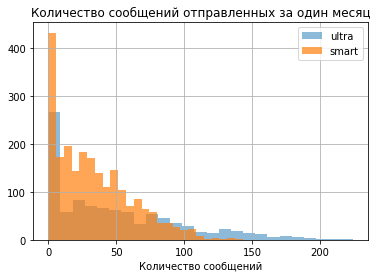

In [31]:
df_ultra['number_of_messages'].hist(bins=25,alpha=0.5,label='ultra')
df_smart['number_of_messages'].hist(bins=25,alpha=0.7,label='smart')
plt.legend(loc='upper right')
plt.title('Количество сообщений отправленных за один месяц')
plt.xlabel('Количество сообщений')
plt.show()

Гистограмма пользователей тарифа 'Ультра' более вытянутая ,по сравнению с гистограммой 'Смарт'. Пик на 0,означает что пользователи некоторые пользователи совсем не пользуются сообщениями.На гистограмме "распределение Пуассона".

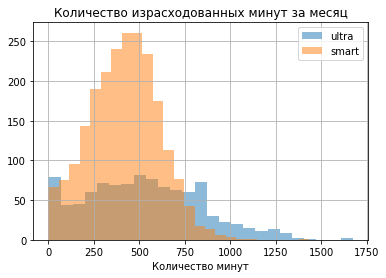

In [32]:
df_ultra['sum_duration'].hist(bins=25,alpha=0.5,label = 'ultra')
df_smart['sum_duration'].hist(bins=25,alpha=0.5,label = 'smart')
plt.legend(loc ='upper right')
plt.title('Количество израсходованных минут за месяц')
plt.xlabel('Количество минут')
plt.show()


Гистограмма пользователей тарифа 'Ультра' более вытянутая ,по сравнению с гистограммой 'Смарт'.

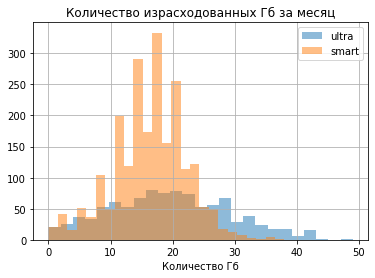

In [33]:
df_ultra['gb_used'].hist(bins=25,alpha=0.5,label = 'ultra')
df_smart['gb_used'].hist(bins=25,alpha=0.5,label = 'smart')
plt.legend(loc = 'upper right')
plt.title('Количество израсходованных Гб за месяц')
plt.xlabel('Количество Гб')
plt.show()

Гистограмма пользователей тарифа 'Ультра' более вытянутая ,по сравнению с гистограммой 'Смарт'.На гистограмме нормальное распределение.

### Сравнение выручек между тарифами

In [34]:
ultra = df.loc[df['tariff'] == 'ultra','revenue']
smart = df.loc[df['tariff'] == 'smart','revenue']
moscow = df.loc[df['city'] == 'Москва','revenue']
no_moscow = df.loc[df['city'] != 'Москва','revenue']


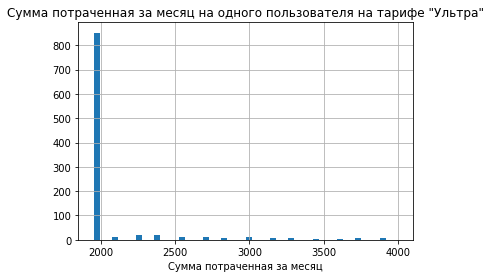

In [35]:
ultra.hist(bins=50,range=(1950,4000))
plt.title('Сумма потраченная за месяц на одного пользователя на тарифе "Ультра"')
plt.xlabel('Сумма потраченная за месяц')
plt.show()
           

In [36]:
print('Выручка не равная 1950 в выборке встречается -',len(ultra[ultra != 1950]))
print('Выручка равная 1950 в выборке встречается -',len(ultra[ultra == 1950]))
print('Средняя выручка в выборке на тарифе "Ультра"-',ultra.mean())

Выручка не равная 1950 в выборке встречается - 134
Выручка равная 1950 в выборке встречается - 852
Средняя выручка в выборке на тарифе "Ультра"- 2070.030425963489


В выборке тарифа "Ультра", в 852 случах из 986  укладываются в лимиты тарифа,это 86,4%.Средняя выручка в выборке на тарифе ультра 2070.

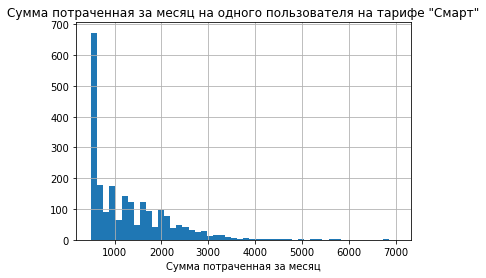

In [37]:
smart.hist(bins=50,range=(500,7000))
plt.title('Сумма потраченная за месяц на одного пользователя на тарифе "Смарт"')
plt.xlabel('Сумма потраченная за месяц')
plt.show()

In [38]:
print(smart.describe())
print('Количество пользователей укладывающихся в лимиты тарифа-',len(smart[smart==550]))

count    2230.000000
mean     1289.641704
std       818.370799
min       550.000000
25%       550.000000
50%      1021.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64
Количество пользователей укладывающихся в лимиты тарифа- 568


Средняя выручка по тарифу "Смарт" равна 1290р, в лимиты тарифа укладываются 568 раз из 2230,это 25,6% .Медиана 1021р,а в 75% случаев укладываются в 1750р

## Проверяем гипотезы

### Проверим гипотезу о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт»

In [39]:
ultra_var = np.var(ultra)
ultra_var

141244.31956107615

In [40]:
smart_var = np.var(smart)
smart_var

669430.4361979931

Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая.
Альтернативная гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [41]:
alpha = .05

results = st.ttest_ind(ultra,smart,equal_var = False)

print('р-значение:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
  

р-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


H0: средняя выручка на тарифе ультра равна 1950 

H1: средняя выручка на тарифе ультра отличается от 1950 в большую сторону

In [42]:
value = 1950
alpha =0.05

results = st.ttest_1samp(ultra,value,alternative = 'greater')

print('р-значение:',results.pvalue)

if results.pvalue < alpha and ultra.mean()>value:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    

р-значение: 6.945354723724928e-23
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу альтернативной,средняя выручка на тарифе "Ультра" отличается от 1950 в большую сторону.Что в целом логично,так как минимальный платеж 1950,и средняя выручка никак не может быть меньше этого числа.
Проверим следующую гипотезу.

H0: Средняя выручка на тарифе "Смарт" равна 1950.

H1: Средняя выручка на тарифе "Смарт" отличается от 1950 в меньшую сторону.

In [43]:
value = 1950
alpha =0.05

results = st.ttest_1samp(smart,value,alternative = 'less')

print('р-значение:',results.pvalue)

if results.pvalue < alpha and smart.mean()<value:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    

р-значение: 2.1353762946519057e-245
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу альтернативной.Средняя выручка на тарифе "Смарт" отличается от 1950 в меньшую сторону.Следует,что средняя выручка на тарифе"Смарт" меньше средней выручки на тарифе "Ультра".

### Сравнение выручек между пользователями из Москвы и из других городов

In [44]:
moscow_var = np.var(moscow)
moscow_var

564710.7117467273

In [45]:
no_moscow_var = np.var(no_moscow)
no_moscow_var

653818.4925923498

H0:средняя выручка пользователей города Москвы = средней выручке пользователей других город.

H1:средние выручки различаются.

In [46]:
alpha = 0.05

results = st.ttest_ind(moscow,no_moscow,equal_var=False)


print('р-значение:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


р-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу,средняя выручка от пользователей города Москвы не отличается от средней выручки пользователей других городов.

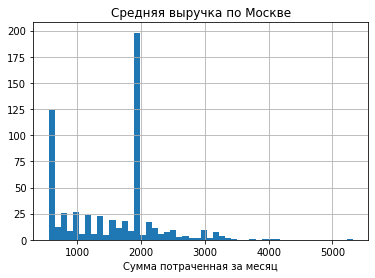

In [47]:
moscow.hist(bins=50)
plt.title('Средняя выручка по Москве')
plt.xlabel('Сумма потраченная за месяц')
plt.show()

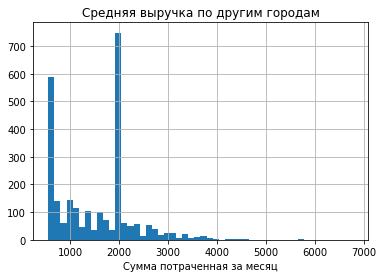

In [48]:
no_moscow.hist(bins=50)
plt.title('Средняя выручка по другим городам')
plt.xlabel('Сумма потраченная за месяц')
plt.show()

## Общий вывод <a name="conclusion"></a>

В среднем пользователи тарифа "Ультра" больше использовали минут,сообщений и гб,чем пользователи тарифа "Смарт".В выборке тарифа "Ультра", в 852 случах из 986  укладываются в лимиты тарифа,это 86,4%.Средняя выручка в выборке на тарифе ультра 2070.В выборке средняя выручка по тарифу "Смарт" равна 1290р, в лимиты тарифа укладываются 568 раз из 2230,это 25,6% .Медиана 1021р,а в 75% случаев укладываются в 1750р.
Средняя выручка на тарифе"Смарт" меньше средней выручки на тарифе "Ультра".Средняя выручка от пользователей города Москвы не отличается от средней выручки пользователей других городов.  
Для компании "Мегалайн" выгоднее рекламировать тариф "Ультра". Рекламу необходимо запускать не только в  Москве,но и в других городах.